<a href="https://colab.research.google.com/github/cesargar1507/DatasetsUB/blob/main/pruebaAeroman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [544]:
!pip install catboost
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool


In [545]:
ruta = "https://raw.githubusercontent.com/cesargar1507/DatasetsUB/main/movements.csv"
data = pd.read_csv(ruta, sep=",")

In [546]:
data.columns = ['turno', 'matricula', 'aerolinea2', 'inicia_movimiento', 'punto_de_inicio',
                'punto_de_finalizacion', 'motivo_movimiento', 'finaliza_movimiento']

In [547]:
data.head(5)

,turno,matricula,aerolinea2,inicia_movimiento,punto_de_inicio,punto_de_finalizacion,motivo_movimiento,finaliza_movimiento
0,BRAVO,AC241,M,7/1/2022 7:21,INTERIOR H5,RAMPA H5/H6,REALIZAR CORRIDA DE MOTORES,7/1/2022 7:29
1,BRAVO,AC81,K,7/1/2022 11:25,PISTA ALFA,RAMPA H6,INICIO MANTENIMIENTO,7/1/2022 11:30
2,BRAVO,AC241,M,7/1/2022 8:47,RAMPA H5/H6,INTERIOR H5,CAMBIO DE POSICION,7/1/2022 8:54
3,BRAVO,AC43,J,7/1/2022 7:37,INTERIOR H4,Avisame,REALIZAR CORRIDA DE MOTORES,7/1/2022 7:42
4,BRAVO,AC43,J,7/1/2022 7:53,RAMPA H3,RAMPA H3,ESPACIO,7/1/2022 8:03


In [548]:
data.isna().sum()

turno                    0
matricula                0
aerolinea2               0
inicia_movimiento        0
punto_de_inicio          0
punto_de_finalizacion    1
motivo_movimiento        0
finaliza_movimiento      0
dtype: int64

In [549]:
data = data.dropna()

In [550]:
# Convertir las fechas y horas a formato datetime
data['inicia_movimiento'] = pd.to_datetime(data['inicia_movimiento'])
data['finaliza_movimiento'] = pd.to_datetime(data['finaliza_movimiento'])

<ipython-input-550-5786e88208e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['inicia_movimiento'] = pd.to_datetime(data['inicia_movimiento'])


In [551]:
# Calcular la duración del movimiento en minutos
data['duracion'] = (data['finaliza_movimiento'] - data['inicia_movimiento']).dt.total_seconds() / 60

In [552]:
data['duracion'].describe()

count    5183.000000
mean        7.949836
std        42.913781
min     -1418.000000
25%         5.000000
50%         7.000000
75%        12.000000
max       161.000000
Name: duracion, dtype: float64

Se identifican casos atipicos donde el tiempo de finalizacion del movimiento es previo al tiempo de inicio, esos datos seran eliminados del dataset

In [553]:
data = data[data['duracion'] >= 0]

In [554]:
data['duracion'].describe()

count    5155.000000
mean        9.962755
std         9.711365
min         0.000000
25%         5.000000
50%         7.000000
75%        12.000000
max       161.000000
Name: duracion, dtype: float64

In [555]:
# Análisis de frecuencia de movimientos por turno
turno_counts = data['turno'].value_counts()
print(turno_counts)

turno
BRAVO      2423
CHARLIE    2106
DELTA       626
Name: count, dtype: int64


In [556]:
# Análisis de duración de movimientos por turno
duracion_por_turno = data.groupby('turno')['duracion'].describe()
print(duracion_por_turno)

          count       mean        std  min  25%  50%   75%    max
turno                                                            
BRAVO    2423.0   8.999175   8.920050  0.0  4.0  7.0  10.0  133.0
CHARLIE  2106.0  10.701804  10.518003  0.0  5.0  8.0  13.0  161.0
DELTA     626.0  11.206070   9.476237  0.0  5.0  9.0  14.0   89.0


<ipython-input-557-9c5f8cb5be0a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hora'] = data['inicia_movimiento'].dt.hour


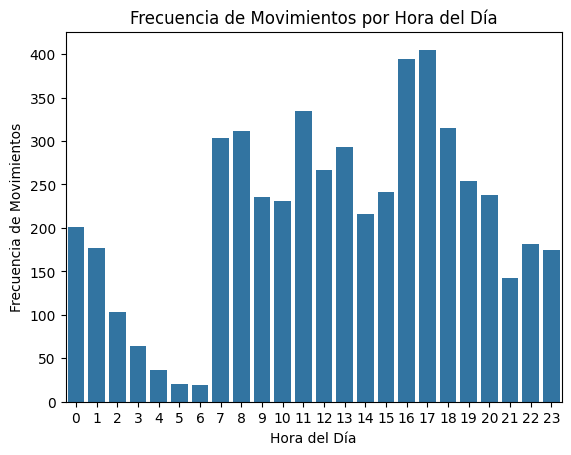

In [557]:
# Visualización de la frecuencia de movimientos por hora del día
data['hora'] = data['inicia_movimiento'].dt.hour
sns.countplot(x='hora', data=data)
plt.title('Frecuencia de Movimientos por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Frecuencia de Movimientos')
plt.show()

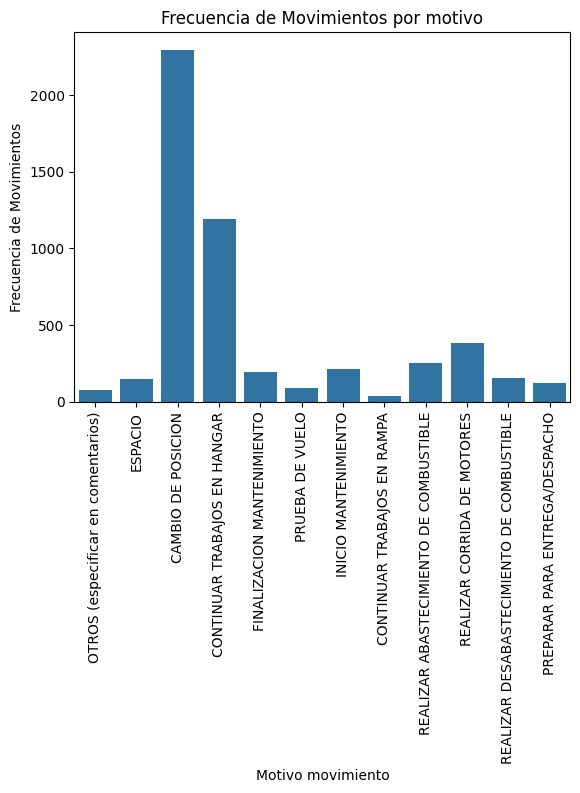

In [576]:
# Visualización de la frecuencia de movimientos por motivo de movimiento
sns.countplot(x='motivo_movimiento', data=data)
plt.title('Frecuencia de Movimientos por motivo')
plt.xlabel('Motivo movimiento')
plt.ylabel('Frecuencia de Movimientos')
plt.xticks(rotation=90)
plt.show()

In [558]:
# Análisis de trayectorias más comunes
trayectorias = data.groupby(['punto_de_inicio', 'punto_de_finalizacion']).size().reset_index(name='count')
trayectorias = trayectorias.sort_values('count', ascending=False)
print(trayectorias.head(20))

      punto_de_inicio punto_de_finalizacion  count
163          RAMPA H5           INTERIOR H5    255
61        INTERIOR H5              RAMPA H5    241
72        INTERIOR H6              RAMPA H6    240
186          RAMPA H6           INTERIOR H6    232
167          RAMPA H5              RAMPA H5    193
150          RAMPA H4           INTERIOR H4    180
53        INTERIOR H4              RAMPA H4    173
69        INTERIOR H6           INTERIOR H6    123
191          RAMPA H6              RAMPA H6    113
57        INTERIOR H5           INTERIOR H5     91
39        INTERIOR H3              RAMPA H3     82
130          RAMPA H3           INTERIOR H3     82
207  ROMPE VIENTOS H7           INTERIOR H6     74
27        INTERIOR H2              RAMPA H2     73
6     CALLE DE RODAJE              RAMPA H5     70
81         PISTA ALFA              RAMPA H5     70
104          RAMPA H2           INTERIOR H2     69
74        INTERIOR H6      ROMPE VIENTOS H7     67
15        INTERIOR H1          

In [569]:
# Crear columna concatenada
data['movimiento'] = data['punto_de_inicio'] + ' a ' + data['punto_de_finalizacion']

# Ordenar los datos por fecha y por movimiento completo
data = data.sort_values(by=['movimiento','inicia_movimiento'])

# Identificar solapamientos entre movimientos completos
solapamientos = []
for i in range(len(data) - 1):
    current_end = data.iloc[i]['finaliza_movimiento']
    next_start = data.iloc[i + 1]['inicia_movimiento']
    if next_start < current_end:
        solapamientos.append(data.iloc[i]['movimiento'])

In [570]:
# Convertir la lista de solapamientos a un DataFrame
df_solapamientos = pd.DataFrame(solapamientos, columns=['movimiento'])

In [571]:
# Contar solapamientos por movimiento
solapamientos_count = df_solapamientos['movimiento'].value_counts()

# Mostrar solo los 10 movimientos con más solapamientos
top_10_solapamientos = solapamientos_count.head(10)
print("Top 10 de movimientos con más solapamientos:")
print(top_10_solapamientos)

Top 10 de movimientos con más solapamientos:
movimiento
RAMPA H6 a INTERIOR H6       23
RAMPA H5 a INTERIOR H5       10
INTERIOR H6 a RAMPA H6        9
INTERIOR H6 a INTERIOR H6     8
INTERIOR H5 a RAMPA H5        7
INTERIOR H5 a INTERIOR H5     6
RAMPA H4 a INTERIOR H4        6
INTERIOR H4 a RAMPA H4        5
RAMPA H1 a INTERIOR H1        4
INTERIOR H1 a RAMPA H1        3
Name: count, dtype: int64


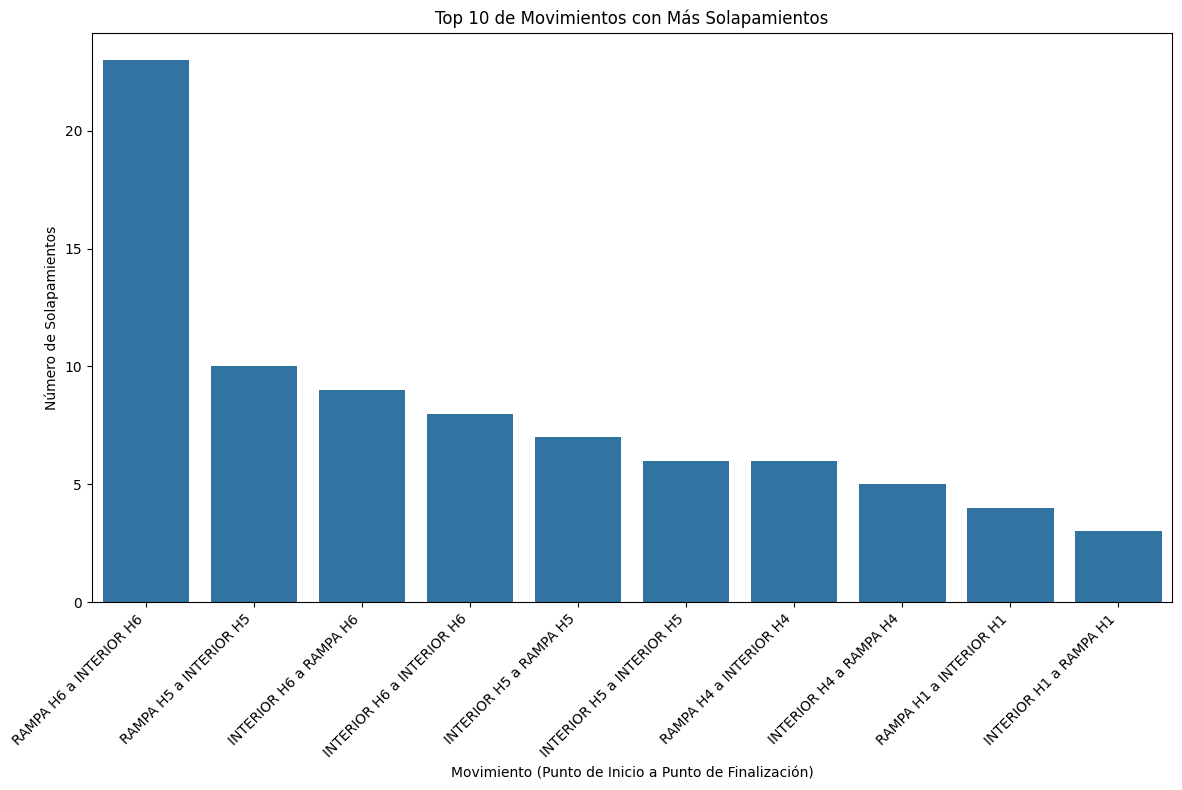

In [573]:
# Visualización de los 10 movimientos con más solapamientos
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_solapamientos.index, y=top_10_solapamientos.values)
plt.title('Top 10 de Movimientos con Más Solapamientos')
plt.xlabel('Movimiento (Punto de Inicio a Punto de Finalización)')
plt.ylabel('Número de Solapamientos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

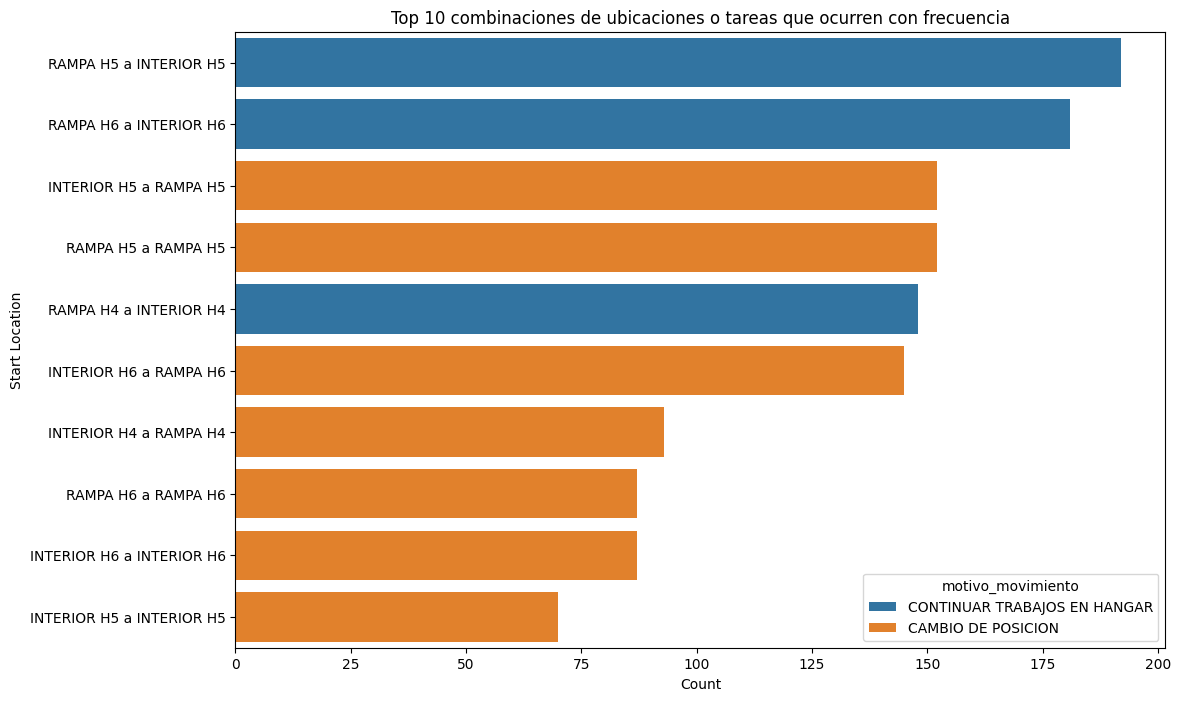

In [584]:
# Contar la frecuencia de combinaciones de ubicaciones y tareas
combination_counts = data.groupby(["movimiento", "motivo_movimiento"]).size().reset_index(name='Count')

# Ordenar por frecuencia en orden descendente
combination_counts = combination_counts.sort_values(by='Count', ascending=False)

# Visualizar las combinaciones más frecuentes
top_combinations = combination_counts.head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='movimiento', hue='motivo_movimiento', data=top_combinations)
plt.title('Top 10 combinaciones de ubicaciones o tareas que ocurren con frecuencia')
plt.xlabel('Count')
plt.ylabel('Start Location')
plt.show()

In [585]:
# Seleccionar características (variables independientes) y variable objetivo (duración_min)
X = data[['turno', 'motivo_movimiento', 'matricula', 'aerolinea2','punto_de_inicio','punto_de_finalizacion']]
y = data['duracion']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo CatBoostRegressor
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', random_state=42)
catboost_model.fit(X_train, y_train, cat_features=[0, 1, 2, 3, 4, 5], eval_set=(X_test, y_test), verbose=100)

# Hacer predicciones
y_pred_catboost = catboost_model.predict(X_test)

# Calcular métricas de evaluación
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)

print("Mean Squared Error (MSE) - CatBoost:", mse_catboost)
print("Coefficient of Determination (R^2) - CatBoost:", r2_catboost)

0:	learn: 9.7924711	test: 8.9465193	best: 8.9465193 (0)	total: 14.2ms	remaining: 14.2s
100:	learn: 8.6578091	test: 8.5688346	best: 8.5535822 (66)	total: 508ms	remaining: 4.52s
200:	learn: 8.1966848	test: 8.6007855	best: 8.5535822 (66)	total: 1.01s	remaining: 4.02s
300:	learn: 7.7992483	test: 8.6410367	best: 8.5535822 (66)	total: 1.46s	remaining: 3.38s
400:	learn: 7.4632378	test: 8.6933037	best: 8.5535822 (66)	total: 1.93s	remaining: 2.88s
500:	learn: 7.1229051	test: 8.7456462	best: 8.5535822 (66)	total: 2.36s	remaining: 2.35s
600:	learn: 6.8550216	test: 8.7580938	best: 8.5535822 (66)	total: 3.32s	remaining: 2.21s
700:	learn: 6.5733826	test: 8.7855014	best: 8.5535822 (66)	total: 4.33s	remaining: 1.85s
800:	learn: 6.2954724	test: 8.8021466	best: 8.5535822 (66)	total: 5.29s	remaining: 1.31s
900:	learn: 6.0536977	test: 8.8428185	best: 8.5535822 (66)	total: 5.89s	remaining: 647ms
999:	learn: 5.8111429	test: 8.8796111	best: 8.5535822 (66)	total: 6.32s	remaining: 0us

bestTest = 8.553582197
b

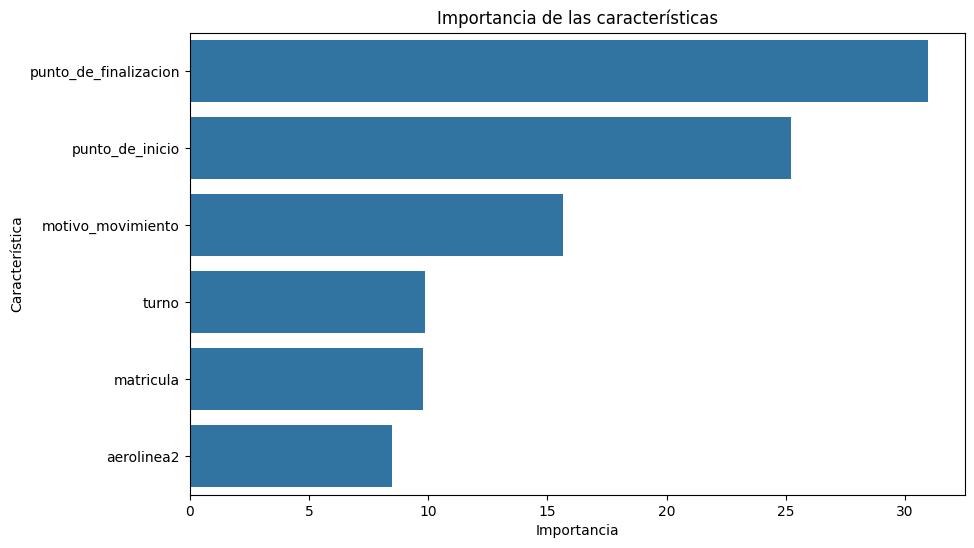

In [586]:
# Obtener un resumen de los parámetros del modelo
feature_importance = catboost_model.get_feature_importance()

# Obtener los nombres de las características
feature_names = X.columns

# Crear un DataFrame con la importancia de las características y sus nombres
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Ordenar el DataFrame por importancia de características
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Crear un gráfico de barras para visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importancia de las características')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()

Se identifica que los factores de importancia para definir la duración de los traslados son en mayor medida el punto de fin, el punto de inicio y el motivo del movimiento, son los factores que explican en mayor medida la variable dependiente

In [587]:
# Definir manualmente los valores para cada característica del nuevo dato
nuevo_dato = pd.DataFrame({
    'turno': ['BRAVO'],
    'motivo_movimiento': ['REALIZAR DESABASTECIMIENTO DE COMBUSTIBLE'],
    'matricula': ['AC15'],
    'aerolinea2': ['C'],
    'punto_de_inicio': ['INTERIOR H4'],
    'punto_de_finalizacion': ['RAMPA H4']
})

# Realizar la predicción utilizando el modelo CatBoost
duracion_predicha = catboost_model.predict(nuevo_dato)

print("Duración predicha:", duracion_predicha)

Duración predicha: [6.12040077]


A falta de datos, no es posible establecer un modelo para predecir con un ajuste adecuado la duración de un movimiento con base a los predictores disponibles, sin embargo, con más datos podría realizarse un modelo más robusto para mejorar la exactitud, se propone realizar un modelo de clasificación